# Tool Calling in Agent Workflows

## What is Tool Calling?

**Tool calling** allows a workflow or agent to **execute actions**, not just generate text.

Instead of only responding with language, the model can:
- Call external functions
- Query databases
- Use APIs
- Perform computations

---

## Why Tool Calling is Important

LLMs are good at reasoning, but **actions require tools**.

Tool calling bridges the gap between:
- **Thinking** (LLM reasoning)
- **Doing** (real-world execution)

---

In [1]:
## LLM used 
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

print(llm.invoke("Hello, How are you?"))

content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?" additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2026-01-12T16:57:03.045439Z', 'done': True, 'done_reason': 'stop', 'total_duration': 18279803208, 'load_duration': 2672760583, 'prompt_eval_count': 31, 'prompt_eval_duration': 12582802625, 'eval_count': 47, 'eval_duration': 2128646662, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'} id='lc_run--019bb323-77c5-7981-817b-aaa3b56785bb-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 31, 'output_tokens': 47, 'total_tokens': 78}


---

#### Lets define the **tools** first

In [36]:
from langchain_core.tools import tool 
from langgraph.prebuilt import ToolNode, tools_condition

######## calculator tool ###################
@tool 
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform basic basic arithematic operation on two numbers.
    Add, subtract, multiply divide 
    """
    try:
        if operation == 'add' or '+':
            result = first_num + second_num 
        elif operation == 'subtract' or '-':
            result = first_num - second_num 
        elif operation == 'multiply' or '*':
            result = first_num * second_num 
        elif operation == 'division' or '/':
            if second_num == 0:
                return {"error" : "Division by zero is not allow"}
            else:
                result = round(first_num/second_num, 2)
        else:
            return {'error' : f"Unsupported operation : {operation}"}

        return {'first_num' : first_num, 'second_num' : second_num, 'operation' : operation, 'result' : result}
    
    except Exception as e:
        return {'error' : {e}}
    
### Binding tools with LLM
tools = [calculator]
llm_with_tools = llm.bind_tools(tools)

In [37]:
# lets make a simple flow 
from langgraph.graph import StateGraph, START, END 
from langchain_core.messages import BaseMessage, HumanMessage 
from langchain_core.prompts import PromptTemplate
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated 

class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [38]:
#define the chat node with LLM 
def chat_llm(state: ChatState) -> ChatState:
    template = """
                You are given with a query and some data. Think carefully what need to be done for this query and generate a final answer. 
                Given query and some data : {messages}
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['messages']
    )

    chain = prompt | llm_with_tools

    response = chain.invoke({'messages' : state['messages']})

    return {
        'messages' : [response]
    }

## tool node
tool_node = ToolNode(tools)

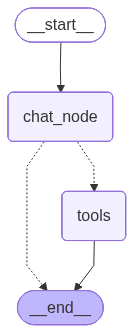

In [39]:
graph = StateGraph(ChatState)

# add nodes 
graph.add_node("chat_node", chat_llm)
graph.add_node("tools", tool_node)

# add edges 
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
# graph.add_edge('tools', 'chat_node')

# compile 
chatbot = graph.compile()


from IPython.display import Image 
Image(chatbot.get_graph().draw_mermaid_png())


In [40]:
input_state = {'messages' : [HumanMessage(content="What will be 2 + 2")]}
output_state = chatbot.invoke(input_state)

In [41]:
output_state

{'messages': [HumanMessage(content='What will be 2 + 2', additional_kwargs={}, response_metadata={}, id='f5a71606-c4c4-46b2-b6da-9355c9f4fce6'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-12T18:26:45.646096Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12536312292, 'load_duration': 228429208, 'prompt_eval_count': 264, 'prompt_eval_duration': 8557620708, 'eval_count': 29, 'eval_duration': 2852262210, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019bb375-b009-7603-ac15-259da444f07a-0', tool_calls=[{'name': 'calculator', 'args': {'first_num': 2, 'operation': '+', 'second_num': 2}, 'id': '19e70264-251a-494a-886c-0f804aa75500', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 264, 'output_tokens': 29, 'total_tokens': 293}),
  ToolMessage(content='{"first_num": 2.0, "second_num": 2.0, "operation": "+", "result": 4.0}', name='calculator', id='426f4

In [42]:
from pprint import pprint
pprint(output_state['messages'][-1].content)

'{"first_num": 2.0, "second_num": 2.0, "operation": "+", "result": 4.0}'
